## Import Packages // Helper Functions

In [954]:
import pandas as pd, sys, re, datetime, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta

%matplotlib inline

In [955]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

## Import Data

In [956]:
url = "https://aisgaiap.blob.core.windows.net/aiap5-assessment-data/traffic_data.csv"
df = pd.read_csv(url, parse_dates = ['date_time'])
print(df.shape)
df.head()

(8573, 9)


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,New Years Day,263.49,0.0,0,58,Clouds,broken clouds,2013-01-01 00:00:00,1439
1,None,263.78,0.0,0,40,Clouds,scattered clouds,2013-01-01 01:00:00,1502
2,None,264.16,0.0,0,75,Snow,heavy snow,2013-01-01 02:00:00,933
3,None,263.95,0.0,0,90,Clouds,overcast clouds,2013-01-01 03:00:00,576
4,None,263.65,0.0,0,90,Clouds,overcast clouds,2013-01-01 04:00:00,372


In [957]:
df.dtypes

holiday                        object
temp                          float64
rain_1h                       float64
snow_1h                         int64
clouds_all                      int64
weather_main                   object
weather_description            object
date_time              datetime64[ns]
traffic_volume                  int64
dtype: object

## Checking Granularity of Dataframe

The Traffic Data is on day-hourly level. Below checks the granularity of the dataframe.

In [958]:
df['date_time'].nunique()

7294

There are 7294 unique hourly day records out of the total 8573 records in the dataframe. There could have been repeated records of weather conditions for the same hour a specified day. Hence, roughly around 85% (7294/8573) of the data is accurate.

In [959]:
df['date_time'].value_counts().head()

2013-04-18 22:00:00    6
2013-05-19 10:00:00    6
2013-06-01 02:00:00    5
2013-05-19 06:00:00    5
2013-02-11 10:00:00    5
Name: date_time, dtype: int64

In [960]:
# check on the highest repeated hourly day
df[df['date_time'] == '2013-05-04 17:00:00']

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
3196,None,275.61,0.0,0,90,Rain,light rain,2013-05-04 17:00:00,4614
3197,None,275.61,0.0,0,90,Mist,mist,2013-05-04 17:00:00,4614
3198,None,275.61,0.0,0,90,Drizzle,light intensity drizzle,2013-05-04 17:00:00,4614


#### Fixing the weather description field

I noticed that the field is not cleaned due to lower case and upper case of the text 'sky is clear'. I aim to fix the field in the below codes. This is to facilitate the fixing of granularity.

In [961]:
df['weather_description'] = df['weather_description'].str.lower()

#### Fixing the dataframe

There are repeated date_time values seen. The variability comes from weather_main and weather_description variables. Since this repeated values will cause data inaccuracy, I will concatenate the categories in the weather_main and weather_description so as to fix the granularity of the dataframe.

In [962]:
# Get the repeated date_time values
rep_date = pd.DataFrame(df['date_time'].value_counts()).reset_index()
rep_date = pd.DataFrame(rep_date[rep_date['date_time'] > 1]['index'])
rep_date.rename(columns = {'index': 'date_time'}, inplace = True)

In [963]:
# To ensure concatenation of weather_main strings is done correctly, avoid duplicates
df.sort_values(by = 'weather_main', inplace = True)
df.reset_index(inplace = True, drop = True)

In [964]:
# Concatenation of weather_main and weather_description
df_rep = pd.merge(df, rep_date, how = 'inner', on = 'date_time')
df_rep_wt_main = pd.DataFrame(df_rep.groupby(df_rep.columns.difference(['weather_main', 'weather_description']).tolist())['weather_main'].apply(lambda x: "%s" % ', '.join(x.unique()))).reset_index()
df_rep_wt_desc = pd.DataFrame(df_rep.groupby('date_time')['weather_description'].apply(lambda x: "%s" % ', '.join(x.unique()))).reset_index()
df_rep = pd.merge(df_rep_wt_main, df_rep_wt_desc, how = 'inner', on = 'date_time')

In [965]:
# Remove the repeated rows of date_time
df.drop_duplicates(subset =['date_time', 'traffic_volume'], keep = False, inplace = True)

In [966]:
# Append the new cleaned rows of date_time
df = df.append(df_rep)

/Users/khalishahnadhirah/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


## Removing irrelevant features

In [967]:
df['snow_1h'].value_counts()

0    7294
Name: snow_1h, dtype: int64

Snow_1h feature will be removed as there are no significant values other than 0 in the field.

In [968]:
df.drop('snow_1h', axis = 1, inplace = True)

## Extract Date Specific Features from date_time 
- Month
- Quarter
- Week
- Day
- Weekday Name
- Hour

In [969]:
# extract information from Dates (date_time)
def add_datepart(df, date_field, drop=False, time=False, errors="raise"):
    fld = df[date_field]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[date_field] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', date_field)
    attr = ['Month', 'Quarter', 'Week', 'Day', 'hour', 'Date','Weekday_name']
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
    if drop: 
        df.drop(date_field, axis=1, inplace=True)
        
add_datepart(df, 'date_time')

df['date_timeDate'] =  pd.to_datetime(df['date_timeDate'], format='%Y-%m-%d')

In [970]:
df.head()

,clouds_all,date_time,holiday,rain_1h,temp,traffic_volume,weather_description,weather_main,date_timeMonth,date_timeQuarter,date_timeWeek,date_timeDay,date_timehour,date_timeDate,date_timeWeekday_name
0,1,2013-03-24 15:00:00,None,0.0,276.10,4502,sky is clear,Clear,3,1,12,24,15,2013-03-24,Sunday
1,0,2013-08-27 21:00:00,None,0.0,302.76,2787,sky is clear,Clear,8,3,35,27,21,2013-08-27,Tuesday
2,8,2013-08-27 16:00:00,None,0.0,306.79,6653,sky is clear,Clear,8,3,35,27,16,2013-08-27,Tuesday
3,8,2013-08-27 14:00:00,None,0.0,306.24,5883,sky is clear,Clear,8,3,35,27,14,2013-08-27,Tuesday
4,0,2013-08-26 23:00:00,None,0.0,301.02,1133,sky is clear,Clear,8,3,35,26,23,2013-08-26,Monday


## Investigate Numerical Features

I am adding temperatures in Degrees Celsius for easy interpretability for future analysis.

In [971]:
df['temp_deg'] = df['temp'] - 273.15

### - Univariate Analysis

In [972]:
df_num = df[['temp', 'temp_deg', 'rain_1h', 'clouds_all', 'traffic_volume']]
df_num.describe()

,temp,temp_deg,rain_1h,clouds_all,traffic_volume
count,7294.000000,7294.000000,7294.000000,7294.00000,7294.000000
mean,279.261794,6.111794,0.088310,47.68385,3309.552783
std,13.822825,13.822825,1.176471,37.61459,2030.708683
min,244.820000,-28.330000,0.000000,0.00000,164.000000
25%,268.972500,-4.177500,0.000000,1.00000,1225.250000
50%,278.220000,5.070000,0.000000,64.00000,3369.000000
75%,291.350000,18.200000,0.000000,90.00000,5026.000000
max,308.240000,35.090000,55.630000,100.00000,7217.000000


### Observations:
- Temperatures are on average 6.1 degrees celsius, cold temperatures, with a min of -28.3 deg and max of 35.0 deg throughout 2013.
- There are minimal rainfall, on average 0.08 mm, min 0 mm and max 55.6 mm throughout 2013.
- There are on average 47.7% cloud cover, with high variability.
- For our variable in concern, traffic volume, we have min of 164 vehicles, max of 7217 vehicles and on average 3309 vehicles on I-94 in 2013.

#### (1) Investigating hourly rain amounts

(array([734855., 734862., 734869., 734876., 734883., 734890., 734897.,
        734904., 734911., 734918., 734925., 734932., 734939., 734946.,
        734953., 734960., 734967., 734974., 734981., 734988., 734995.,
        735002., 735009., 735016., 735023., 735030., 735037., 735044.,
        735051., 735058., 735065., 735072., 735079., 735086., 735093.,
        735100., 735107., 735114., 735121., 735128., 735135., 735142.,
        735149., 735156., 735163., 735170., 735177., 735184., 735191.,
        735198., 735205., 735212., 735219., 735226., 735233., 735240.,
        735247.]), <a list of 57 Text xticklabel objects>)

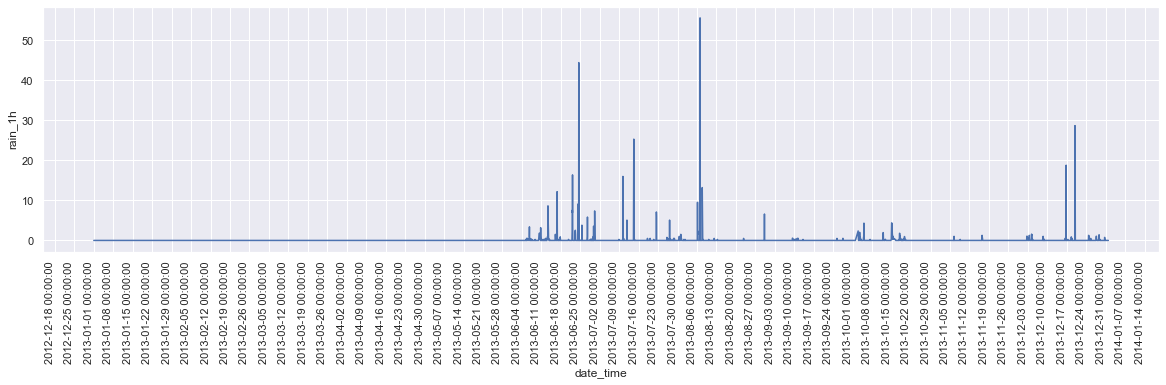

In [973]:
plt.figure(figsize=(20,5))
ax = sns.lineplot(x = 'date_time', y = 'rain_1h', data = df)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90)

There were no rainfall before Jun 2013 so the data for the below plot is filtered to show dates beyond June 2013.

(array([735016., 735023., 735030., 735037., 735044., 735051., 735058.,
        735065., 735072., 735079., 735086., 735093., 735100., 735107.,
        735114., 735121., 735128., 735135., 735142., 735149., 735156.,
        735163., 735170., 735177., 735184., 735191., 735198., 735205.,
        735212., 735219., 735226., 735233., 735240.]),
 <a list of 33 Text xticklabel objects>)

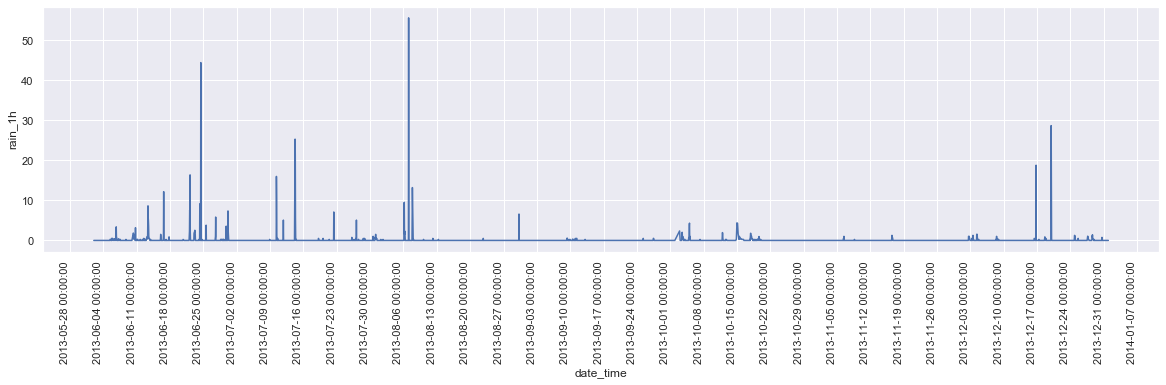

In [974]:
plt.figure(figsize=(20,5))
ax = sns.lineplot(x = 'date_time', y = 'rain_1h', data = df[df['date_timeDate'] > '2013-06-01'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90)

### Observations:
- Rain is fairly sparse between the months of mid August to mid December.
- Rain happens frequently between June and early August, with big spikes happening on end June and early August.

##### Deep dive into the highest rainfall periods

In [975]:
df.sort_values(by = 'rain_1h', ascending = False).head()

,clouds_all,date_time,holiday,rain_1h,temp,traffic_volume,weather_description,weather_main,date_timeMonth,date_timeQuarter,date_timeWeek,date_timeDay,date_timehour,date_timeDate,date_timeWeekday_name,temp_deg
7631,68,2013-08-07 02:00:00,None,55.63,289.10,315,very heavy rain,Rain,8,3,32,7,2,2013-08-07,Wednesday,15.95
6930,76,2013-06-24 11:00:00,None,44.45,295.82,4802,very heavy rain,Rain,6,2,26,24,11,2013-06-24,Monday,22.67
167,64,2013-12-19 23:00:00,None,28.70,264.50,1190,"very heavy rain, light snow","Rain, Snow",12,4,51,19,23,2013-12-19,Thursday,-8.65
30,8,2013-07-14 06:00:00,None,25.32,292.65,958,"mist, very heavy rain, proximity thunderstorm","Mist, Rain, Thunderstorm",7,3,28,14,6,2013-07-14,Sunday,19.50
722,90,2013-07-14 07:00:00,None,21.42,292.87,1745,"mist, very heavy rain, proximity thunderstorm","Mist, Rain, Thunderstorm",7,3,28,14,7,2013-07-14,Sunday,19.72


### Observations:
- Highest rainfall happened only at an hour on 7-8-2013 at 2am.

([<matplotlib.axis.XTick at 0x1a5fd04160>,
 <a list of 24 Text xticklabel objects>)

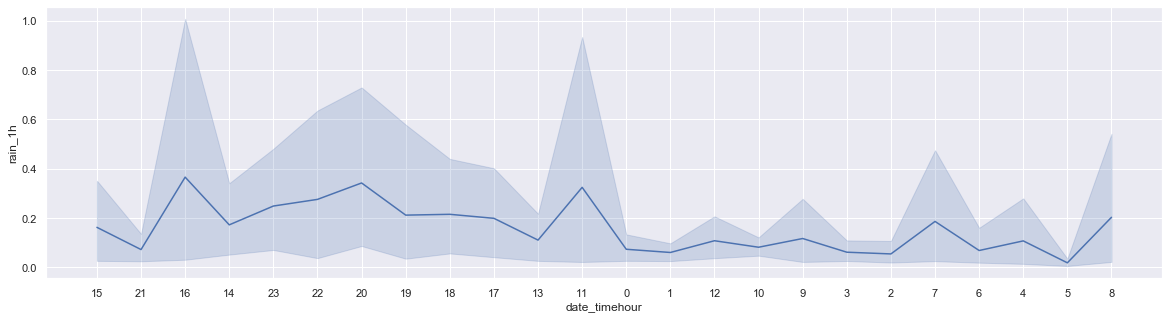

In [976]:
plt.figure(figsize=(20,5))
ax = sns.lineplot(x = 'date_timehour', y = 'rain_1h', data = df[df['date_timeDate'] > '2013-06-01'])
plt.xticks(np.arange(24), df['date_timehour'].unique())

### Observations:
- On average, rain frequently happens between 1am and 12pm, with even high variability.
- Rainfall is more mellow during the day period after 12pm till 12am, with less variability.

#### (2) Investigating hourly temperatures

(array([734855., 734862., 734869., 734876., 734883., 734890., 734897.,
        734904., 734911., 734918., 734925., 734932., 734939., 734946.,
        734953., 734960., 734967., 734974., 734981., 734988., 734995.,
        735002., 735009., 735016., 735023., 735030., 735037., 735044.,
        735051., 735058., 735065., 735072., 735079., 735086., 735093.,
        735100., 735107., 735114., 735121., 735128., 735135., 735142.,
        735149., 735156., 735163., 735170., 735177., 735184., 735191.,
        735198., 735205., 735212., 735219., 735226., 735233., 735240.,
        735247.]), <a list of 57 Text xticklabel objects>)

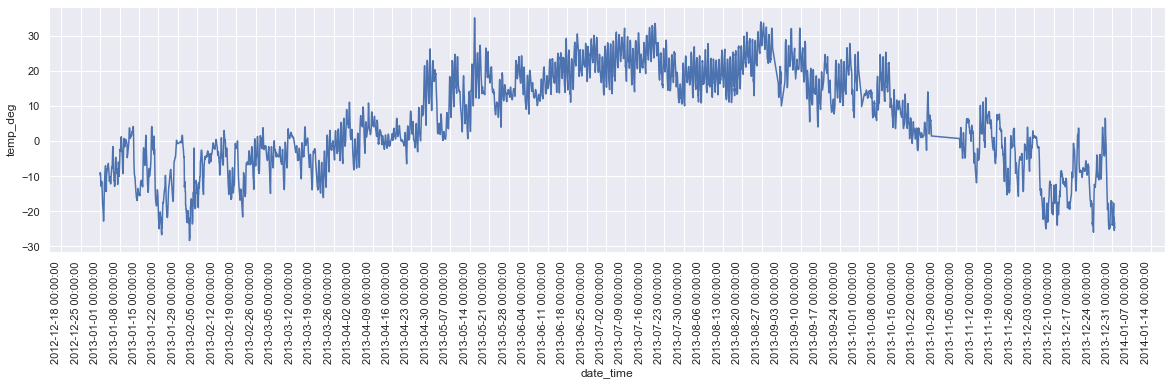

In [977]:
plt.figure(figsize=(20,5))
ax = sns.lineplot(x = 'date_time', y = 'temp_deg', data = df)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90)

### Observations:
- Generally, temperatures are colder between months of January till May.
- It then increases to become hotter between May till October.
- The temperatures peaked around July to August.
- Temperatures will then gradually decreases to below -20 degrees around December.

([<matplotlib.axis.XTick at 0x1a601af550>,
 <a list of 24 Text xticklabel objects>)

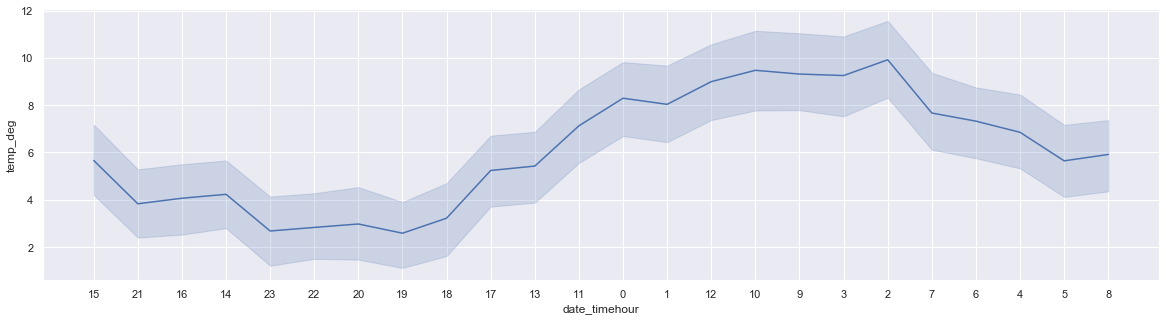

In [978]:
plt.figure(figsize=(20,5))
ax = sns.lineplot(x = 'date_timehour', y = 'temp_deg', data = df)
plt.xticks(np.arange(24), df['date_timehour'].unique())

### Observations:
- Temperatures variability is stable throughout all hours of the day.
- On average, temperatures are below 6 degrees Celsius in the morning before 10am and peaked around 6pm.
- Tempereratures in the day are much higher than in the morning.

#### (3) Investigating hourly cloud covers percentage

([<matplotlib.axis.XTick at 0x1a5a52ef28>,
 <a list of 24 Text xticklabel objects>)

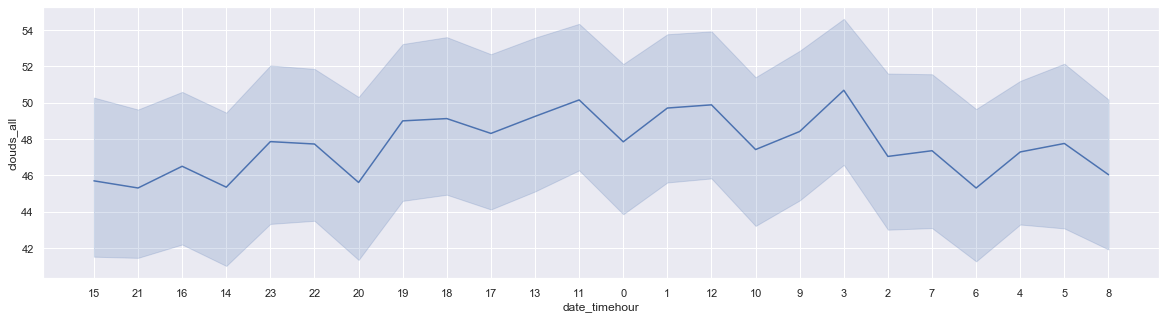

In [979]:
plt.figure(figsize=(20,5))
ax = sns.lineplot(x = 'date_timehour', y = 'clouds_all', data = df)
plt.xticks(np.arange(24), df['date_timehour'].unique())

### Observations:
- Cloud cover variability is stable throughout all hours of the day.
- On average, cloud cover are falls around the mean of the cloud cover percentage at 47%.
- There are more cloud cover, on average, at 5pm.

#### (4) Investigating hourly traffic volume

([<matplotlib.axis.XTick at 0x1a6027e5c0>,
 <a list of 24 Text xticklabel objects>)

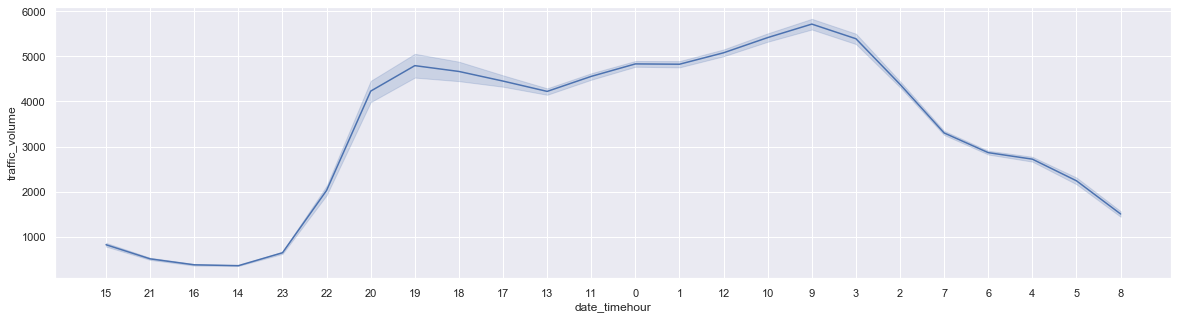

In [980]:
plt.figure(figsize=(20,5))
ax = sns.lineplot(x = 'date_timehour', y = 'traffic_volume', data = df)
plt.xticks(np.arange(24), df['date_timehour'].unique())

### Observations:
- Traffic is low during post midnight hours before sunrise.
- Traffic volumes is high during peak hour period between 6-8am and 3-5pm.
- Traffic variability is high between 6am to 10am.
- Traffic volumes gradually decreases as it approaches midnight.

### - Bivariate Analysis

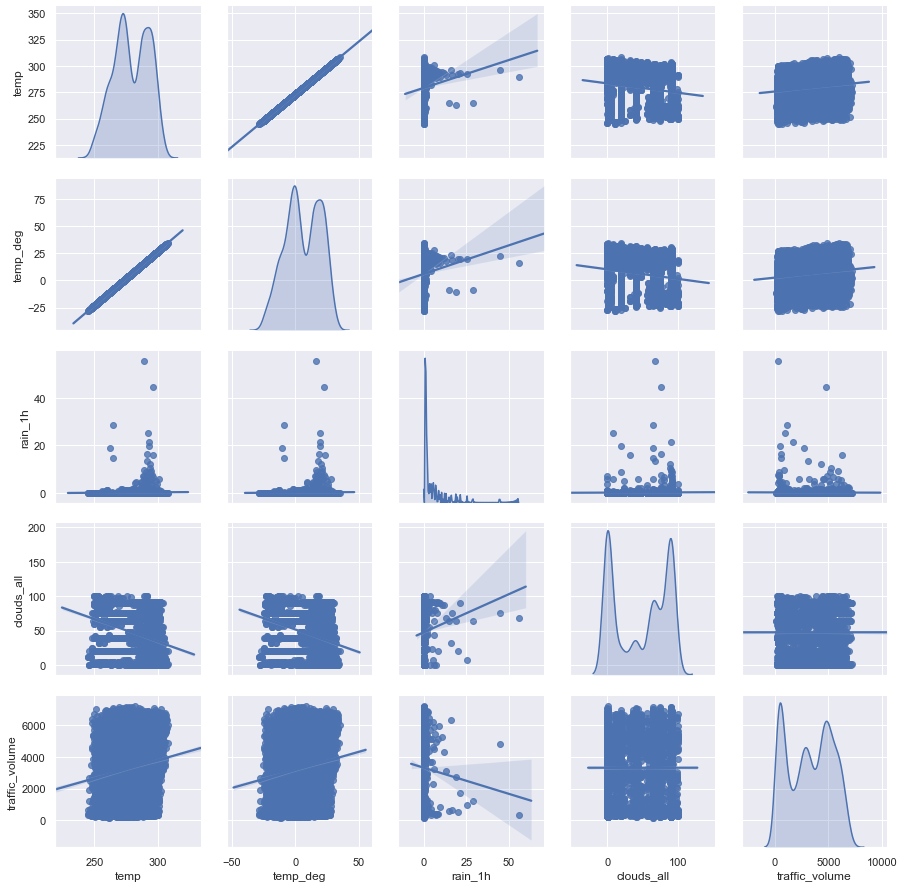

In [981]:
sns.pairplot(df_num, diag_kind = 'kde', kind = 'reg')

### Observations:
#### Impact of numerical features on output
- There is a gentle increase of traffic volume with the increase of temperatures.
- There is negative relationship with rain and traffic volume. Traffic decreases greatly with more rainfall.
- Cloud cover has negligible impact on traffic volume.

#### Interfeature relationships
- Cloud cover increases greatly with increase in rainfall.
- Temperatures increases rapidly with increase in rainfall.
- Temperatures decreases with increase in cloud cover.

### - Multivariate Analysis with Date Features

#### (1) Investigating monthly trends and relationship of traffic volume with rain, cloud cover and temperatures in Degrees Celsius

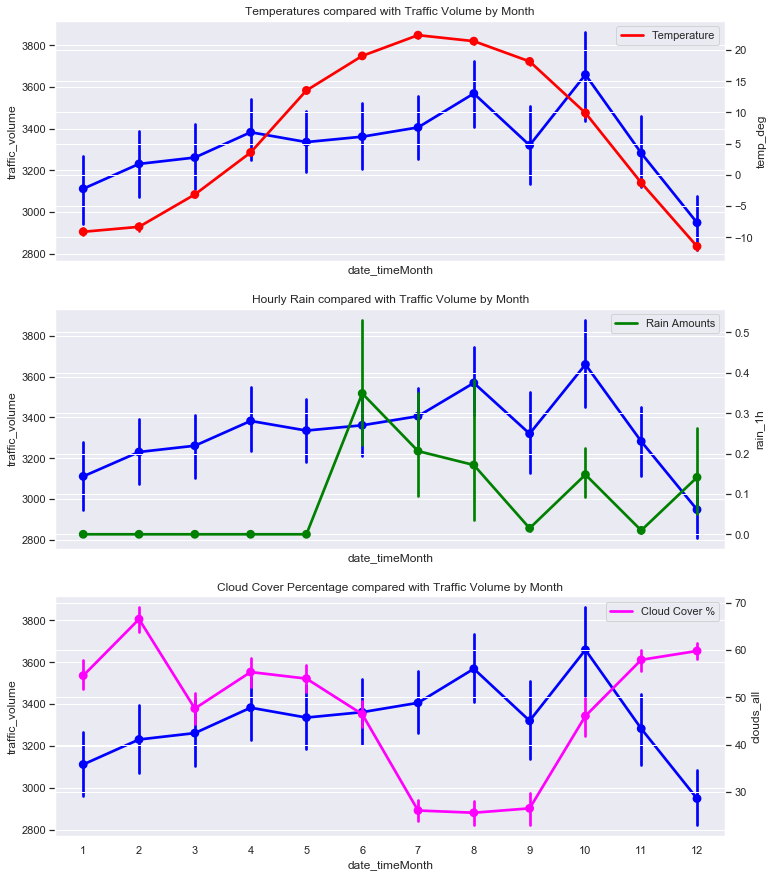

In [982]:
fig, axes = plt.subplots(figsize=(12, 15), nrows = 3, sharex = 'col')

sns.pointplot(x = 'date_timeMonth', y = 'traffic_volume', data = df, color = 'blue', ax = axes[0])
ax1 = axes[0].twinx()
sns.pointplot(x = 'date_timeMonth', y = 'temp_deg', data = df, ax = ax1, color = 'red')
plt.title('Temperatures compared with Traffic Volume by Month')
plt.legend(labels=['Temperature'])

sns.pointplot(x = 'date_timeMonth', y = 'traffic_volume', data = df, color = 'blue', ax = axes[1])
ax2 = axes[1].twinx()
sns.pointplot(x = 'date_timeMonth', y = 'rain_1h', data = df, ax = ax2, color = 'green')
plt.title('Hourly Rain compared with Traffic Volume by Month')
plt.legend(labels=['Rain Amounts'])

sns.pointplot(x = 'date_timeMonth', y = 'traffic_volume', data = df, color = 'blue', ax = axes[2])
ax3 = axes[2].twinx()
sns.pointplot(x = 'date_timeMonth', y = 'clouds_all', data = df, ax = ax3, color = 'magenta')
plt.title('Cloud Cover Percentage compared with Traffic Volume by Month')
plt.legend(labels=['Cloud Cover %'])

Across the 3 plots, blue is the plot for traffic volume.
- Red is for Temperatures
- Green is for Hourly Rain
- Magenta is for Cloud Cover percentage.

### Observations:
- As temperatures gradually increase, the traffic also increases with the exception of October.
- For rainfall observations, the trend of traffic volumes follows closely the trend of hourly rain after August.
- The general trend for the cloud cover tends to show a negative relationship wth traffic volume, with the exceptions of months between (January and February), (March and April) and (September and October).

#### (2) Investigating hourly trends and relationship of traffic volume with rain, cloud cover and temperatures in Degrees Celsius

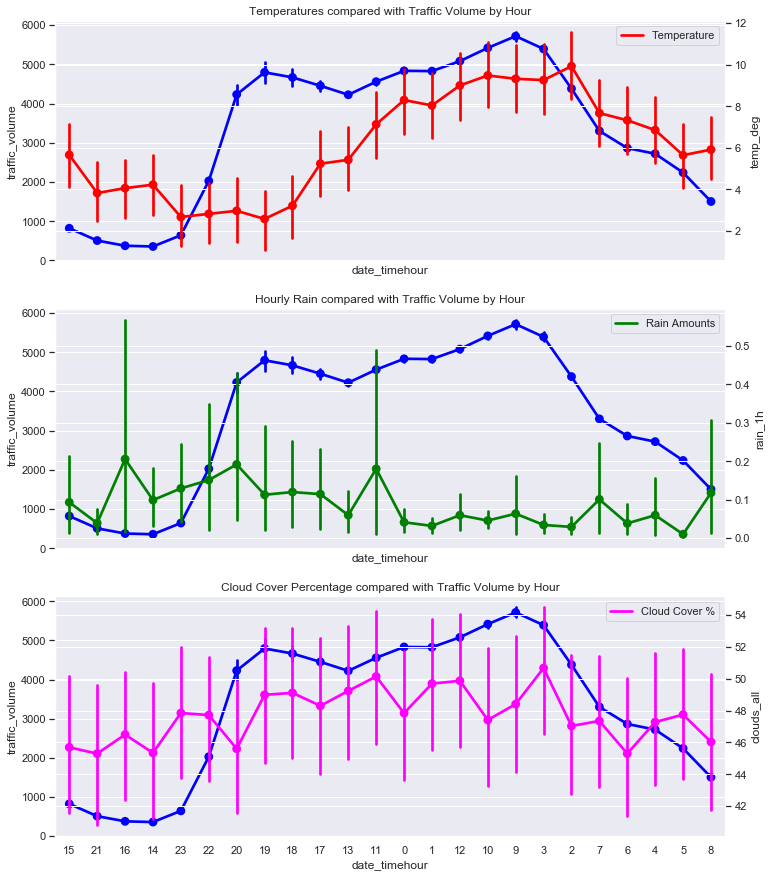

In [983]:
fig, axes = plt.subplots(figsize=(12, 15), nrows = 3, sharex = 'col')

sns.pointplot(x = 'date_timehour', y = 'traffic_volume', data = df, color = 'blue', ax = axes[0])
ax1 = axes[0].twinx()
sns.pointplot(x = 'date_timehour', y = 'temp_deg', data = df, ax = ax1, color = 'red')
plt.xticks(np.arange(24), df['date_timehour'].unique())
plt.title('Temperatures compared with Traffic Volume by Hour')
plt.legend(labels=['Temperature'])


sns.pointplot(x = 'date_timehour', y = 'traffic_volume', data = df, color = 'blue', ax = axes[1])
ax2 = axes[1].twinx()
sns.pointplot(x = 'date_timehour', y = 'rain_1h', data = df, ax = ax2, color = 'green')
plt.xticks(np.arange(24), df['date_timehour'].unique())
plt.title('Hourly Rain compared with Traffic Volume by Hour')
plt.legend(labels=['Rain Amounts'])

sns.pointplot(x = 'date_timehour', y = 'traffic_volume', data = df, color = 'blue', ax = axes[2])
ax3 = axes[2].twinx()
sns.pointplot(x = 'date_timehour', y = 'clouds_all', data = df, ax = ax3, color = 'magenta')
plt.xticks(np.arange(24), df['date_timehour'].unique())
plt.title('Cloud Cover Percentage compared with Traffic Volume by Hour')
plt.legend(labels=['Cloud Cover %'])

Across the 3 plots, blue is the plot for traffic volume.
- Red is for Temperatures
- Green is for Hourly Rain
- Magenta is for Cloud Cover percentage.

### Observations:
- As temperatures gradually increase, the traffic also increases. It follows closely on an hourly basis, especially after 10am.
- For rainfall observations, during the day the trend of traffic volumes is inversely proportional to rain. The lesser the rainfall, the higher the traffic volume.
- Generally, the trends of traffic volume follows the hourly cloud cover percentages, especially during the day between 7am and 8pm. With the exception of hours 12pm and 3pm.

### - Correlation Analysis

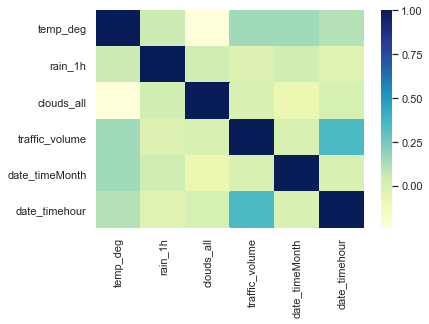

In [984]:
sns.heatmap(df[['temp_deg', 'rain_1h', 'clouds_all', 'traffic_volume', 'date_timeMonth', 'date_timehour']].corr(), cmap="YlGnBu")


### Observations:

- Temperatures have a slightly higher correlation with traffic volume as compared to other features like rain and cloud cover.
- Traffic volume is highly correlated with datetimeHour feature. Will remove this feature, if need be, during modelling.
- Cloud cover has least correlation with temperatures.
- Overall, the features other than datetimeHour are less correlated with the output of traffic volume. Hence, we can use them as features for the model that we will build later on.

## Investigate Categorical Features

### (A) Holiday Feature

#### Fixing Holiday Feature to all the hours of the same day

I noticed that for the subsequent hours in the same day at which the holiday is assigned to, the assignment of the holiday name is not updated correctly. (ie. in 2013-01-01, hours 0100 to 2300 is not updated as New Years Day) The below operations will update the holiday names accordingly.

In [985]:
df_hols = df[df['holiday'] != 'None'][['holiday', 'date_timeDate']]
df_hols

,holiday,date_timeDate
124,Labor Day,2013-09-02
1919,Independence Day,2013-07-04
1972,Columbus Day,2013-10-14
2662,New Years Day,2013-01-01
2783,Thanksgiving Day,2013-11-28
3372,State Fair,2013-08-22
3690,Veterans Day,2013-11-11
4283,Washingtons Birthday,2013-02-18
4875,Memorial Day,2013-05-27
6940,Christmas Day,2013-12-25


In [986]:
df = pd.merge(df, df_hols, how = 'left', on = ['date_timeDate']).drop(columns = 'holiday_x')
df.rename(columns = {'holiday_y': 'holiday'}, inplace = True)
df['holiday'].fillna('None', inplace = True)

#### Introducing flag feature: is_Holiday
The below operation will introduce the flag for holiday (is_Holiday) where 1 is True for holidays and 0 for non-holidays.

In [987]:
df['is_Holiday'] = df['holiday'].apply(lambda x: 1 if x != 'None' else 0)

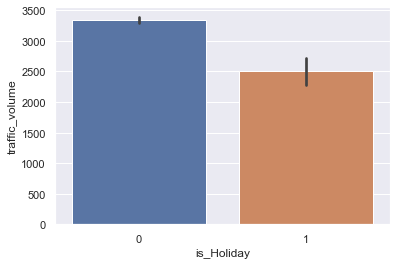

In [988]:
sns.barplot(x = 'is_Holiday', y = 'traffic_volume', data = df)

### Observations:
- The ratio of average traffic volume during holidays to non-holidays is around 5:7. For the 10 days of holiday that US has, the ratio is significant as compared to the remaining 355 days we have in the year of 2013.
- The variability of traffic volume is high during holidays as compared to non-holidays.

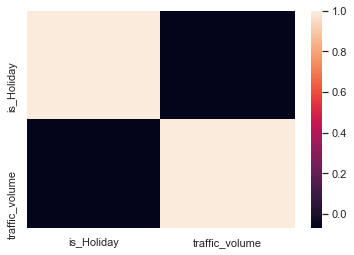

In [989]:
sns.heatmap(df[['is_Holiday', 'traffic_volume']].corr())

### Observations:
- is_Holiday feature is least correlated to traffic volume feature.

In [990]:
df_holiday = pd.DataFrame(df[df['is_Holiday'] == 1].groupby(['holiday', 'date_timeDate','date_timeWeekday_name'])['traffic_volume'].sum()).reset_index()
df_holiday

,holiday,date_timeDate,date_timeWeekday_name,traffic_volume
0,Christmas Day,2013-12-25,Wednesday,32664
1,Columbus Day,2013-10-14,Monday,41630
2,Independence Day,2013-07-04,Thursday,50356
3,Labor Day,2013-09-02,Monday,53637
4,Memorial Day,2013-05-27,Monday,47207
5,New Years Day,2013-01-01,Tuesday,39817
6,State Fair,2013-08-22,Thursday,92767
7,Thanksgiving Day,2013-11-28,Thursday,48235
8,Veterans Day,2013-11-11,Monday,73855
9,Washingtons Birthday,2013-02-18,Monday,74809


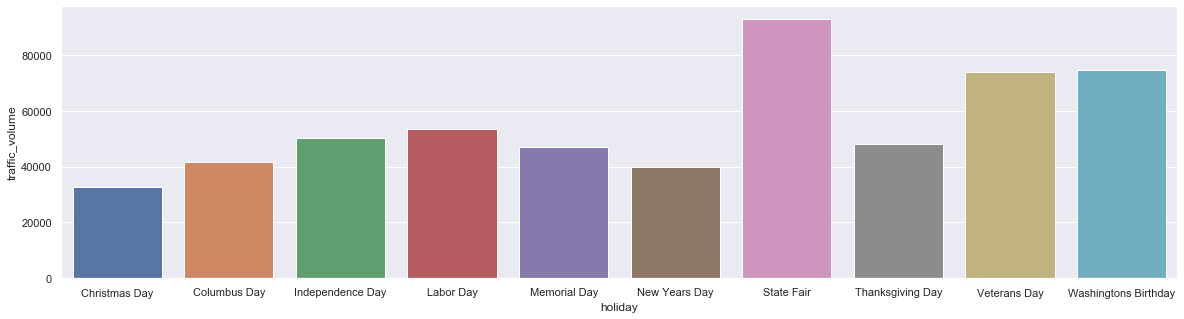

In [991]:
plt.figure(figsize=(20,5))
sns.barplot(x = 'holiday', y = 'traffic_volume', data = df_holiday)

### Observations:
- The holiday of State Fair has the highest traffic count. The biggest state fairs include Minnesota State Fair. Since I-94 covers Minnesota, this could account for the the high traffic count of vehicles going to the state fairs.

#### Investigating Pre and Post Holiday Traffic Volumes
I also decided to investigate the pre and post holidays for any spikes in traffic volumes.

In [992]:
post = pd.DataFrame(df_holiday['date_timeDate'] + timedelta(days = 1)).reset_index()
post['prepost_holiday'] = 'Post '+ df_holiday['holiday']
pre = pd.DataFrame(df_holiday['date_timeDate'] + timedelta(days = -1)).reset_index()
pre['prepost_holiday'] = 'Pre '+ df_holiday['holiday']
hols = pre.append(post, ignore_index = True)
hols.drop(columns = 'index', inplace = True)

In [993]:
prepost = pd.merge(df, hols, how = 'left', on = ['date_timeDate'])
prepost_holiday = pd.DataFrame(prepost[prepost['prepost_holiday'].isnull() == False].groupby(['prepost_holiday', 'date_timeDate','date_timeWeekday_name'])['traffic_volume'].sum()).reset_index()
prepost_holiday.head(10)

,prepost_holiday,date_timeDate,date_timeWeekday_name,traffic_volume
0,Post Christmas Day,2013-12-26,Thursday,63392
1,Post Columbus Day,2013-10-15,Tuesday,40932
2,Post Independence Day,2013-07-05,Friday,69150
3,Post Labor Day,2013-09-03,Tuesday,1129
4,Post Memorial Day,2013-05-28,Tuesday,79273
5,Post New Years Day,2013-01-02,Wednesday,74977
6,Post State Fair,2013-08-23,Friday,93126
7,Post Thanksgiving Day,2013-11-29,Friday,63000
8,Post Veterans Day,2013-11-12,Tuesday,88743
9,Post Washingtons Birthday,2013-02-19,Tuesday,63848


In [994]:
df_prepost = df_holiday.append(prepost_holiday.rename(columns = {'prepost_holiday': 'holiday'}), ignore_index = True).sort_values(by = 'date_timeDate')
df_prepost

,holiday,date_timeDate,date_timeWeekday_name,traffic_volume
5,New Years Day,2013-01-01,Tuesday,39817
15,Post New Years Day,2013-01-02,Wednesday,74977
28,Pre Washingtons Birthday,2013-02-17,Sunday,52930
9,Washingtons Birthday,2013-02-18,Monday,74809
19,Post Washingtons Birthday,2013-02-19,Tuesday,63848
24,Pre Memorial Day,2013-05-26,Sunday,49600
4,Memorial Day,2013-05-27,Monday,47207
14,Post Memorial Day,2013-05-28,Tuesday,79273
22,Pre Independence Day,2013-07-03,Wednesday,85164
2,Independence Day,2013-07-04,Thursday,50356


In [995]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space) + 150
                _y = p.get_y() + p.get_height() - 0.1
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

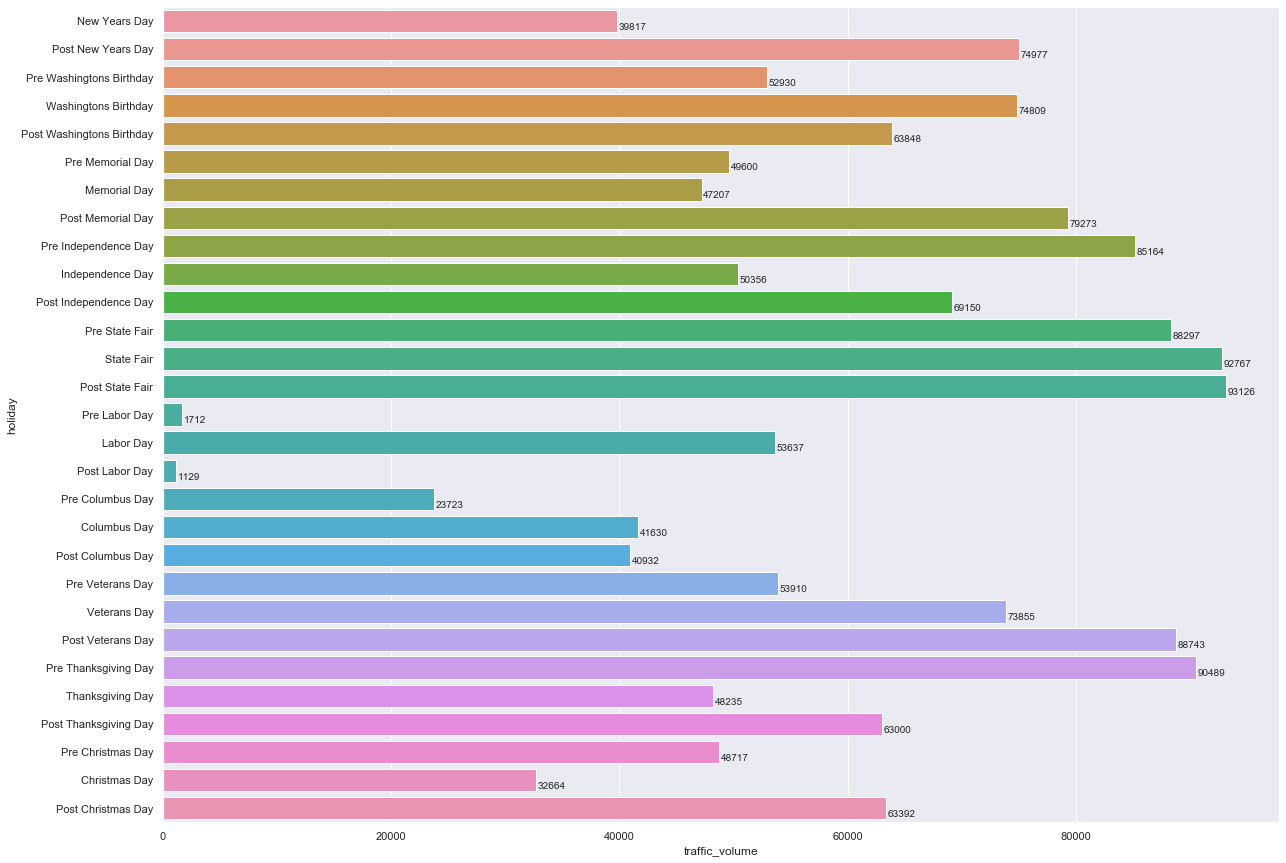

In [996]:
plt.figure(figsize=(20, 15))
ax = sns.barplot(x = 'traffic_volume', y = 'holiday', data = df_prepost)
show_values_on_bars(ax, "h")

### Observations:
- Traffic counts stays high during the pre and post holiday of State Fair.
- Traffic count is high in comparison to the other days during post New Years Day, pre Independence Day, pre Thanksgiving Day, post Veterans Day and post Memorial Day.
- Traffic count is significantly low during the Pre and Post Labor Day.

### (B) Date Feature

#### (1) Investigating Traffic per Day 

In [997]:
# sum all the hourly traffic in a day
df_date = pd.DataFrame(df.groupby(['date_timeDate'])['traffic_volume'].sum()).reset_index()

In [998]:
# sort traffic_volume to get the highest traffic in a day
df_date.sort_values(by = 'traffic_volume', ascending = False).head()

,date_timeDate,traffic_volume
213,2013-08-02,95841
309,2013-11-15,95648
316,2013-11-22,95120
199,2013-07-19,94970
150,2013-05-31,94802


In [999]:
# sort traffic_volume to get the lowest traffic in a day
df_date.sort_values(by = 'traffic_volume', ascending = True).head()

,date_timeDate,traffic_volume
28,2013-01-29,434
299,2013-10-27,822
274,2013-10-02,899
245,2013-09-03,1129
242,2013-08-31,1321


(array([734855., 734862., 734869., 734876., 734883., 734890., 734897.,
        734904., 734911., 734918., 734925., 734932., 734939., 734946.,
        734953., 734960., 734967., 734974., 734981., 734988., 734995.,
        735002., 735009., 735016., 735023., 735030., 735037., 735044.,
        735051., 735058., 735065., 735072., 735079., 735086., 735093.,
        735100., 735107., 735114., 735121., 735128., 735135., 735142.,
        735149., 735156., 735163., 735170., 735177., 735184., 735191.,
        735198., 735205., 735212., 735219., 735226., 735233., 735240.,
        735247.]), <a list of 57 Text xticklabel objects>)

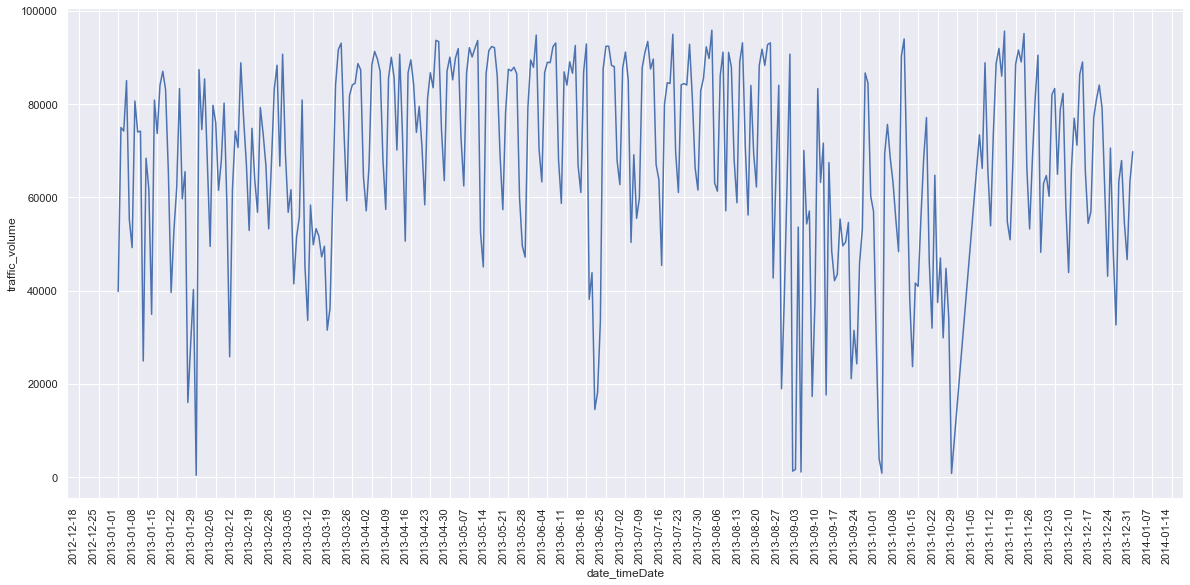

In [1000]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x = 'date_timeDate', y = 'traffic_volume', data = df_date)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90)

### Observations:
In 2013,
- There are low daily values in traffic counts in the end of January, early September, early October and late October.
- Traffic volumes are on average consistently around 70000 verhicles on a daily basis. However, the average between September and October is slightly lower at around 4000s vehicles.
- There is gradual increase in daily counts in traffic from January till March.
- Traffic counts decrease from November to December.

#### (2) Investigating Traffic per hour per day of the week

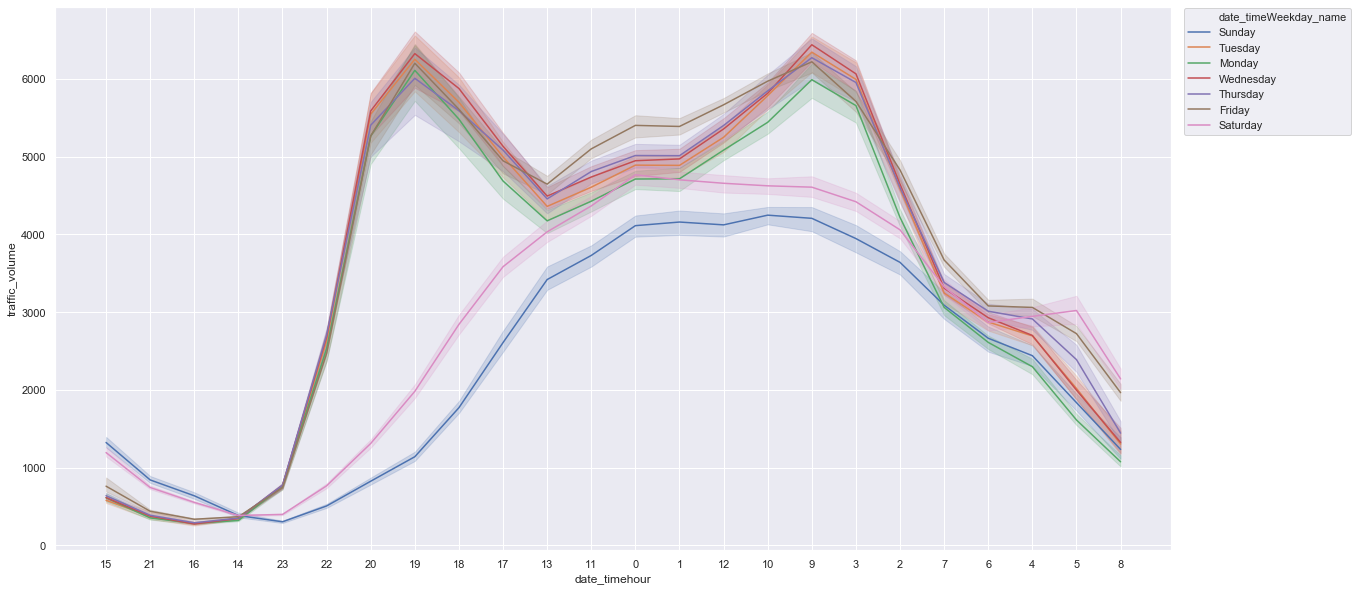

In [1001]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x = 'date_timehour', y = 'traffic_volume', hue = 'date_timeWeekday_name', data = df)
plt.xticks(np.arange(24), df['date_timehour'].unique())
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.1)

### Observations:
- Traffic follows the general cumulative trends of volumes and variability during weekdays.
- Traffic volumes are slightly lower during the weekends, especially between 4am to 6pm.
- Traffic volumes is higher in weekends than weekdays between midnight to 3am.
- Traffic variability is constant during the weekends.

#### (3) Investigating Traffic during day of the week

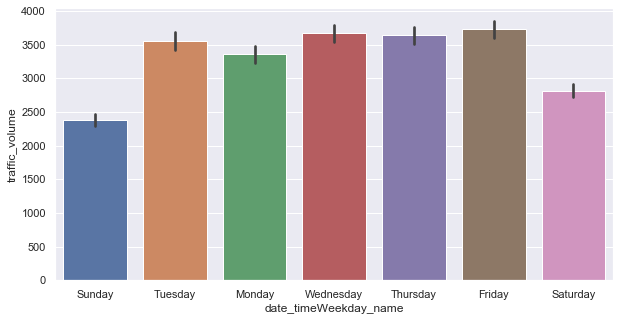

In [1002]:
plt.figure(figsize=(10,5))
sns.barplot(x = 'date_timeWeekday_name', y = 'traffic_volume', data = df)

### Observations:
- Traffic volumes are generally the same throughout all weekdays.
- Traffic volumes are significantly lesser during weekends.
- Traffic volumes is the least on Sunday.

#### (4) Investigating Traffic per Month

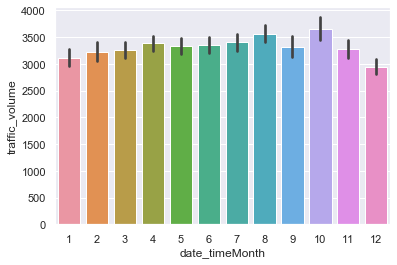

In [1003]:
sns.barplot(x = 'date_timeMonth', y = 'traffic_volume', data = df)

### Observations:
- Traffic volume is the least on December.
- Traffic volume is high on August and October.

#### (5) Investigating Traffic per Month with impact of holidays

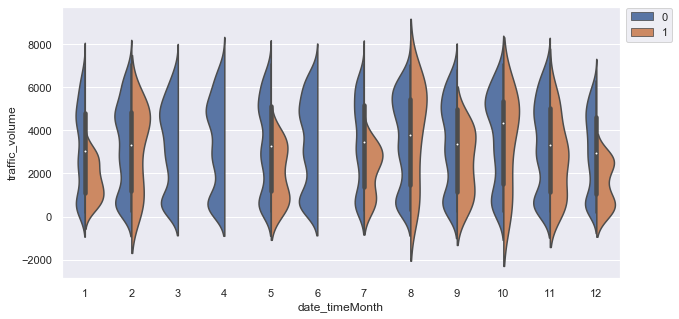

In [1004]:
plt.figure(figsize=(10,5))
sns.violinplot(x = "date_timeMonth", y = "traffic_volume", hue = 'is_Holiday', data = df, split = True)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.1)

### Observations:
- Traffic volume follows the same distribution for non-holiday days of the month.
- For holidays, traffic volume distribution is leaning towards the bigger values on February, August and October while the distribution is leaning towards the lower values on January, May, July and December.

#### (6) Investigating Traffic per Quarter

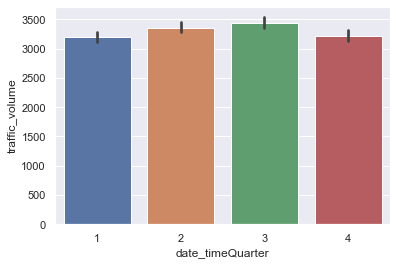

In [1005]:
sns.barplot(x = 'date_timeQuarter', y = 'traffic_volume', data = df)

### Observations:
- Traffic volume is the highest on third quarter of 2013 while its the lowest for both first and last quarter. Last quarter has small traffic volume as evident from December's traffic volumes.

### (C) Weather Text Feature

In [1006]:
# checking the sub weather categories for variability
df_weather = pd.DataFrame(df.groupby('weather_main')['weather_description'].apply(lambda x: "%s" % ', '.join(x.unique()))).reset_index()

# getting count of subconditions per main weather
n = []
for cond in df_weather['weather_description'].tolist():
    cond_indv = cond.split(',')
    num = len(cond_indv)
    n.append(num)
    
df_weather = df_weather.join(pd.DataFrame(n, columns = ['weather_description_num']))
df_weather.head()

,weather_main,weather_description,weather_description_num
0,Clear,sky is clear,1
1,Clouds,"few clouds, overcast clouds, broken clouds, sc...",6
2,Drizzle,"drizzle, light intensity drizzle, heavy intens...",7
3,"Drizzle, Fog, Mist","drizzle, fog, mist, light intensity drizzle, f...",6
4,"Drizzle, Fog, Mist, Rain","drizzle, fog, mist, light rain, light intensit...",13


In [1007]:
df_weather.sort_values(by = 'weather_description_num', ascending = False).head()

,weather_main,weather_description,weather_description_num
37,"Mist, Rain, Thunderstorm","mist, heavy intensity rain, thunderstorm with ...",98
9,"Drizzle, Mist, Rain","heavy intensity drizzle, mist, light rain, lig...",41
35,"Mist, Rain, Snow","mist, moderate rain, light snow, mist, light r...",35
12,"Drizzle, Rain","light intensity drizzle, light rain, light int...",35
43,"Rain, Thunderstorm","moderate rain, proximity thunderstorm, heavy i...",29


In [1008]:
df_wt = pd.merge(df, df_weather[['weather_main', 'weather_description_num']], on = 'weather_main', how = 'left')

#### (1) Investigating Traffic per main Weather conditions

##### For Number of Weather Subconditions less than 3

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

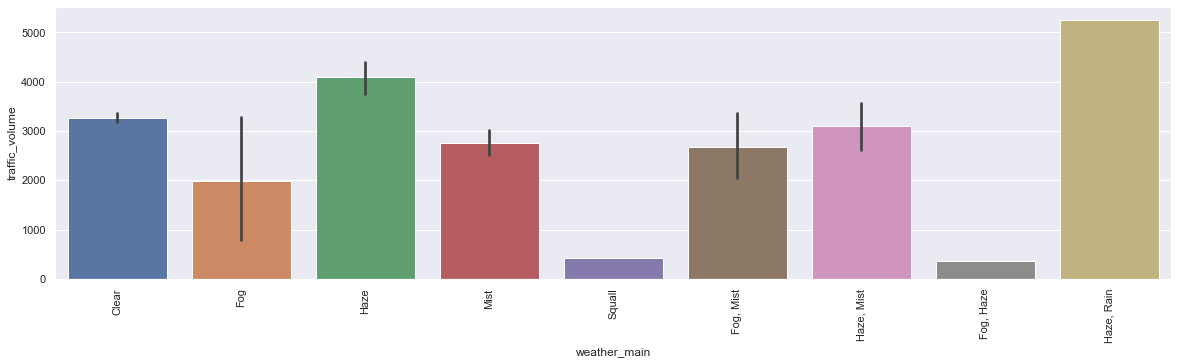

In [1009]:
plt.figure(figsize=(20,5))
sns.barplot(x = 'weather_main', y = 'traffic_volume', data = df_wt[df_wt['weather_description_num'] < 3])
plt.xticks(rotation = 90)

##### For Number of Weather Subconditions less than 5

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

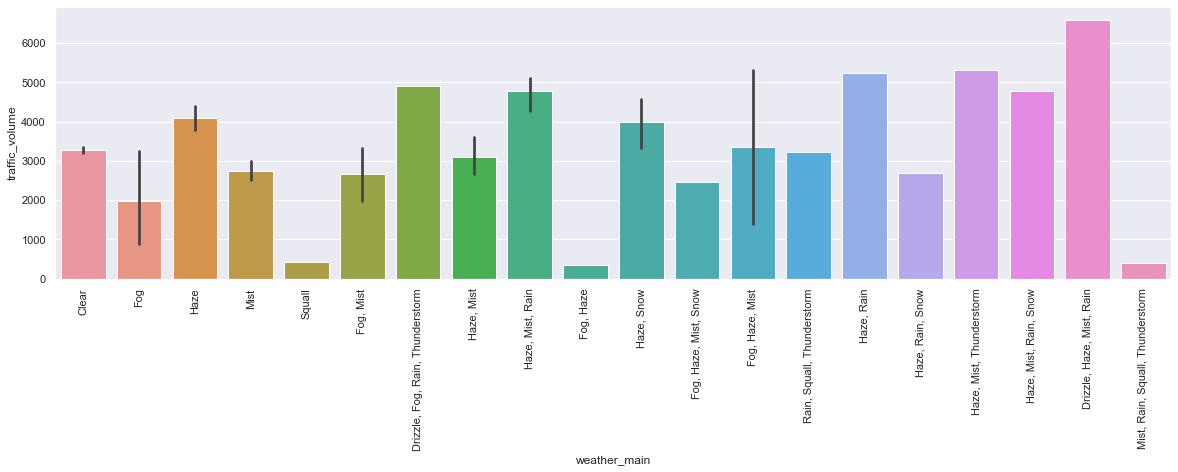

In [1010]:
plt.figure(figsize=(20,5))
sns.barplot(x = 'weather_main', y = 'traffic_volume', data = df_wt[df_wt['weather_description_num'] < 5])
plt.xticks(rotation = 90)

##### For Number of Weather Subconditions more than 30

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

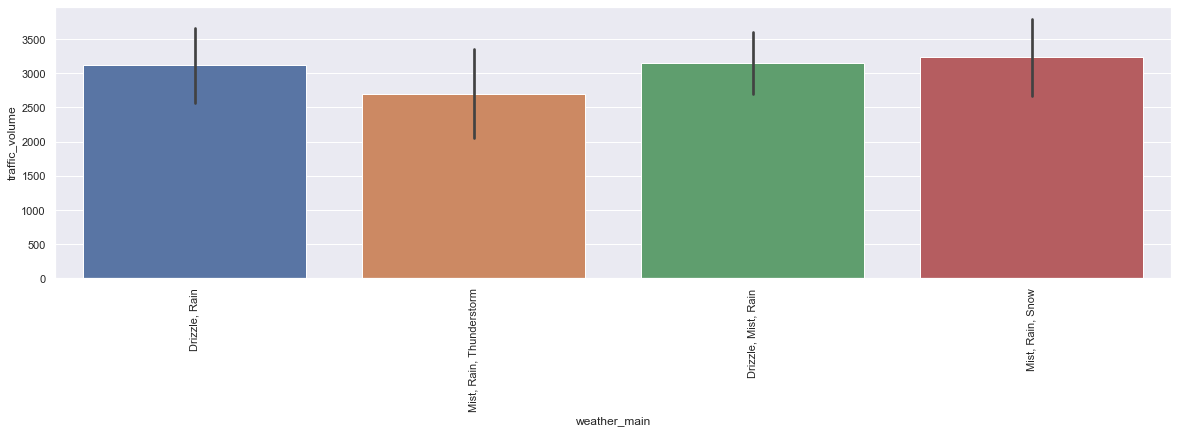

In [1011]:
plt.figure(figsize=(20,5))
sns.barplot(x = 'weather_main', y = 'traffic_volume', data = df_wt[df_wt['weather_description_num'] > 30])
plt.xticks(rotation = 90)

### Observations:
- I can see that for lesser number of weather subconditions (< 3), the traffic volumes are generally higher on average than more number of weather subconditions. (> 30)
- Despite having Rain and Haze, the traffic volumes are much higher. Values goes beyond 5000 volumes in traffic. and
- Squalls and combination of Fog and Haze reduces the traffic volumes to way below 1000 vehicles.

- When I filtered the number of weather subconditions to be less than 5
    - The (combination of Drizzle, Haze, Mist and Rain) do not reduce the traffic conditions hence the volumes are high. The traffic volumes are on average more than 6000.
    - Combination of Mist, Rain, Squall and Thunderstorms reduces the traffic to below 1000 vehicles.

Encoding of weather_main variable to convert to numerical variable to find its specific categories' correlation with traffic_volume.

In [1021]:
df_wt_main = df[['weather_main', 'traffic_volume']]
df_wt_main_encoded = pd.get_dummies(df_wt_main)
df_wt_main_encoded.head()

,traffic_volume,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,"weather_main_Drizzle, Fog, Mist","weather_main_Drizzle, Fog, Mist, Rain","weather_main_Drizzle, Fog, Mist, Rain, Snow","weather_main_Drizzle, Fog, Rain, Thunderstorm","weather_main_Drizzle, Haze, Mist, Rain","weather_main_Drizzle, Mist",...,"weather_main_Mist, Rain, Thunderstorm","weather_main_Mist, Snow","weather_main_Mist, Thunderstorm",weather_main_Rain,"weather_main_Rain, Snow","weather_main_Rain, Squall, Thunderstorm","weather_main_Rain, Thunderstorm",weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm
0,4502,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2787,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6653,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5883,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1133,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


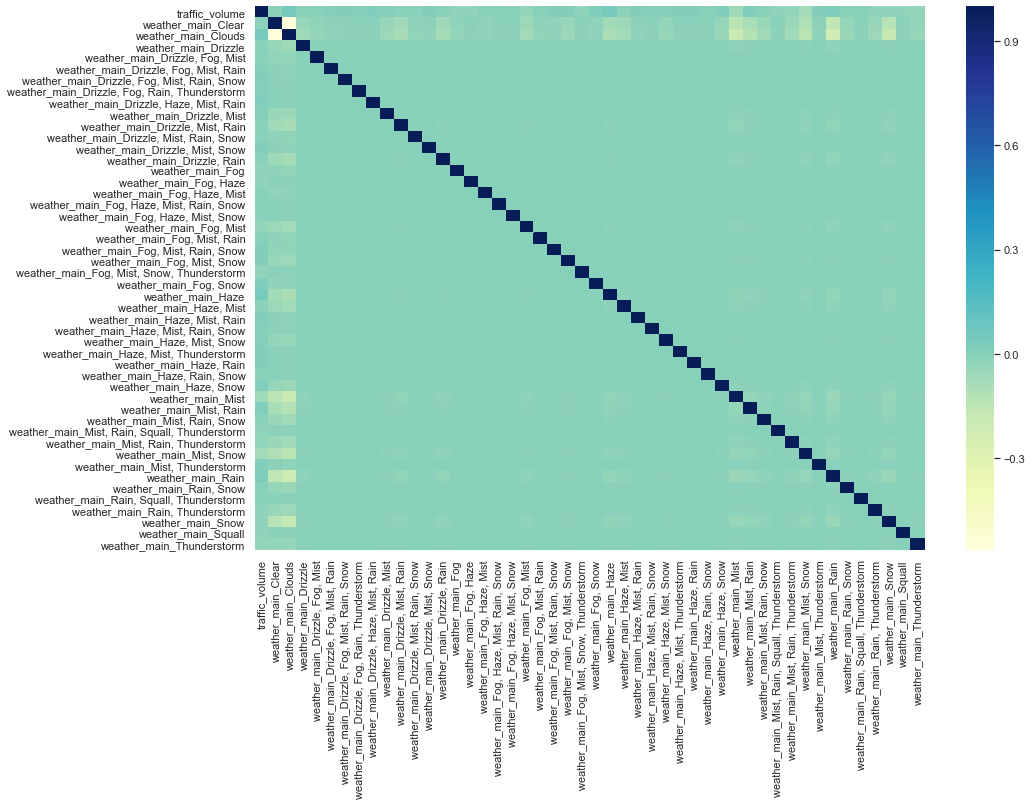

In [1022]:
plt.figure(figsize=(15,10))
sns.heatmap(df_wt_main_encoded.corr(), cmap="YlGnBu")

### Observations:
- All the weather categories has low to negative correlation with traffic volume.

#### (2) Investigating weather conditions in deeper detail - using weather description

I extracted the specific weather descriptions which has more than one description per weather_main field.

In [1032]:
df_haze = df[df['weather_main'] == 'Clouds']
df_drizzle = df[df['weather_main'] == 'Drizzle']
df_rain = df[df['weather_main'] == 'Rain']
df_snow = df[df['weather_main'] == 'Snow']
df_thunder = df[df['weather_main'] == 'Thunderstorm']

weather_list = {'Clouds': df_clouds, 'Drizzle': df_drizzle, 'Rain': df_rain, 'Snow': df_snow, 'Thunder': df_thunder}

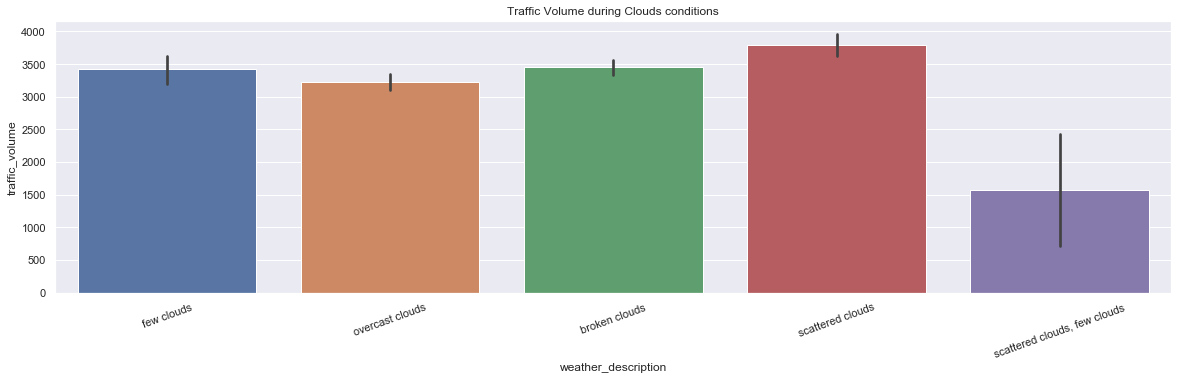

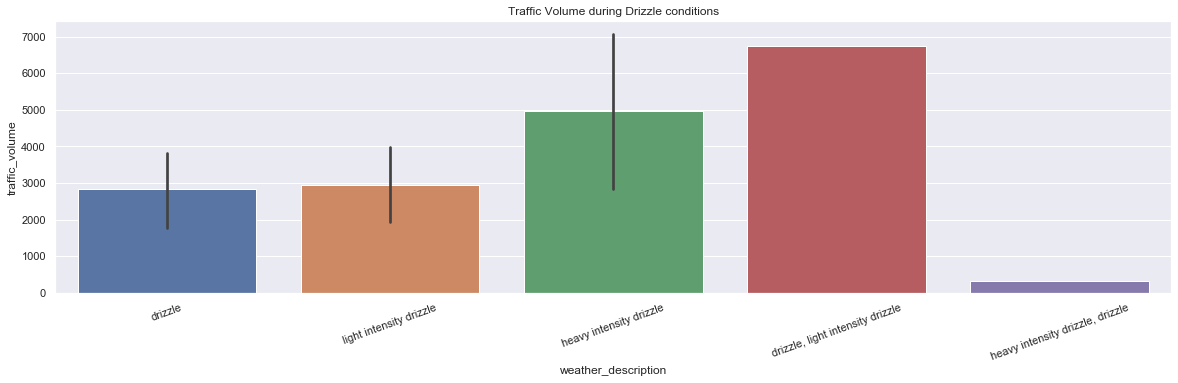

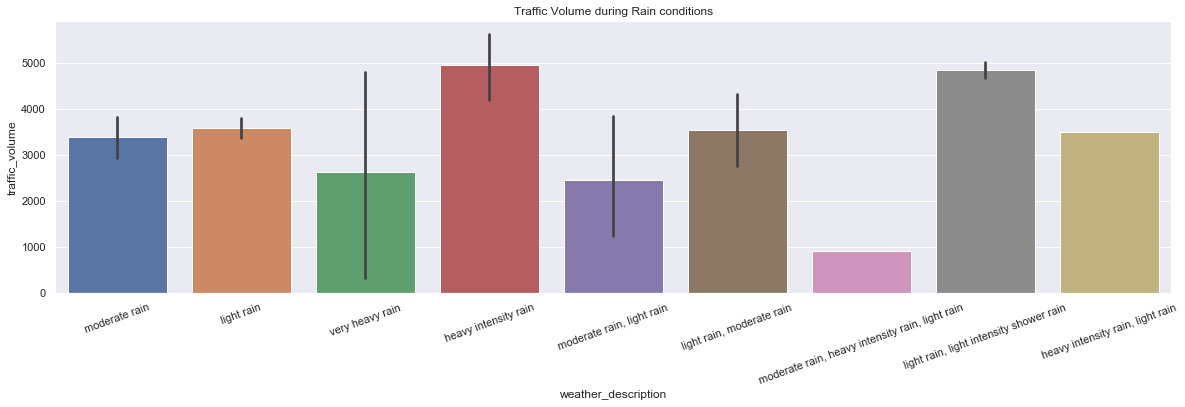

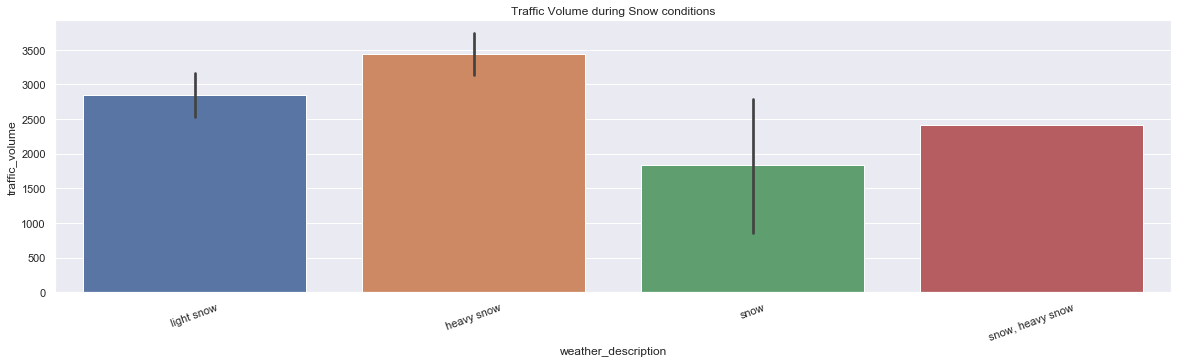

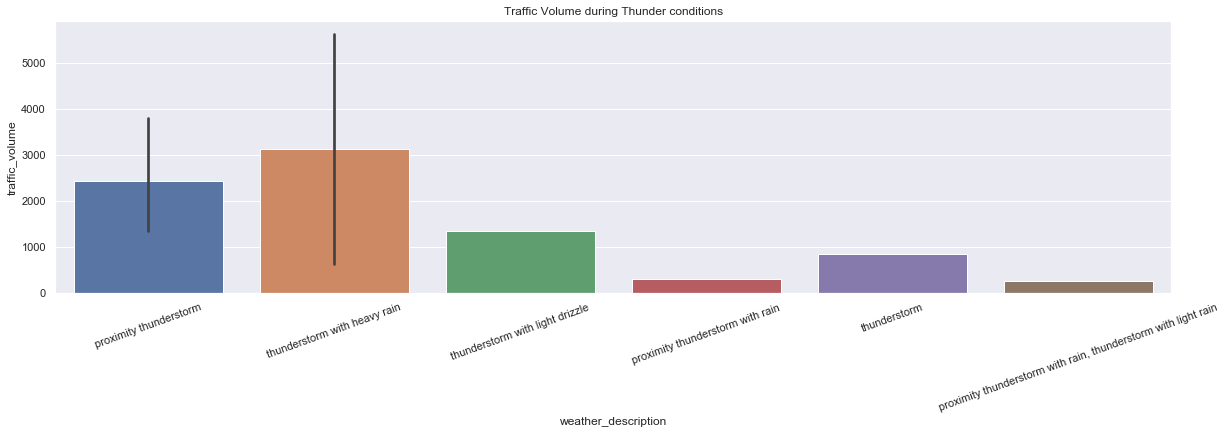

In [1033]:
for key, value in weather_list.items():
    plt.figure(figsize=(20,5))
    sns.barplot(x = 'weather_description', y = 'traffic_volume', data = value)
    plt.xticks(rotation = 20)
    plt.title('Traffic Volume during '+key+' conditions')

### Observations:

1) In the Clouds plot, 
- scattered clouds account for the high volumes of traffic on average.
- scattered clouds with few clouds combination account for the least volumes, with high variability.

2) In the Drizzle plot,
- light intensity drizzle accounts for the most average traffic volumes.
- heavy intensity drizzle significantly reduces the traffic volumes.

3) In the Rain plot,
- heavy intensity rain accounts for high traffic volumes, subsequently light intensity shower rain

4) In the Snow plot,
- heavy snow has the highest volumes of traffic on average.

5) In the Thunder plot,
- this plot has on average lower volumes of traffic than other plots

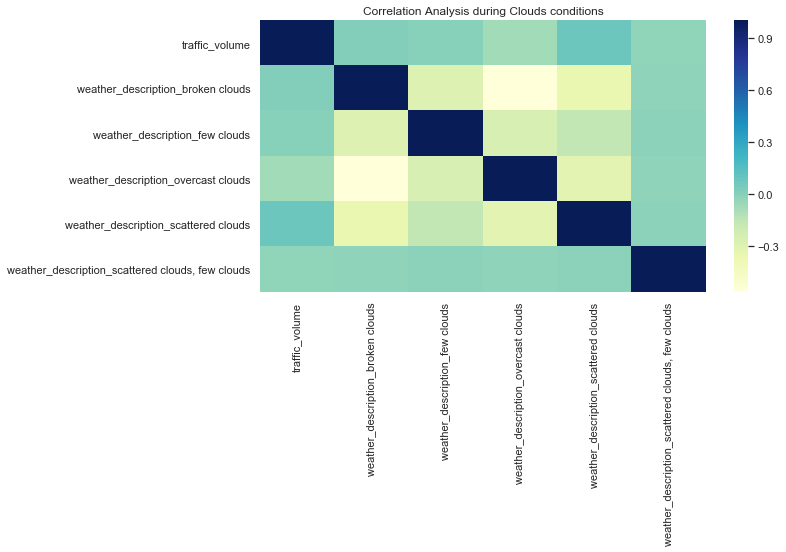

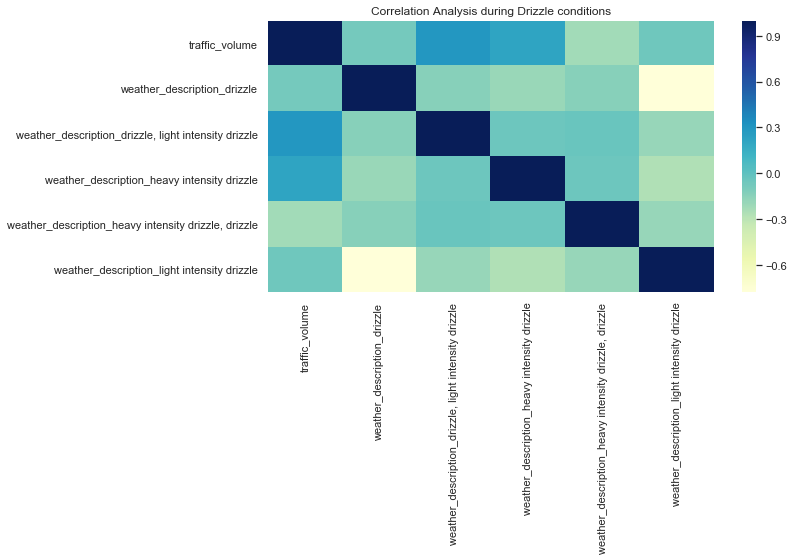

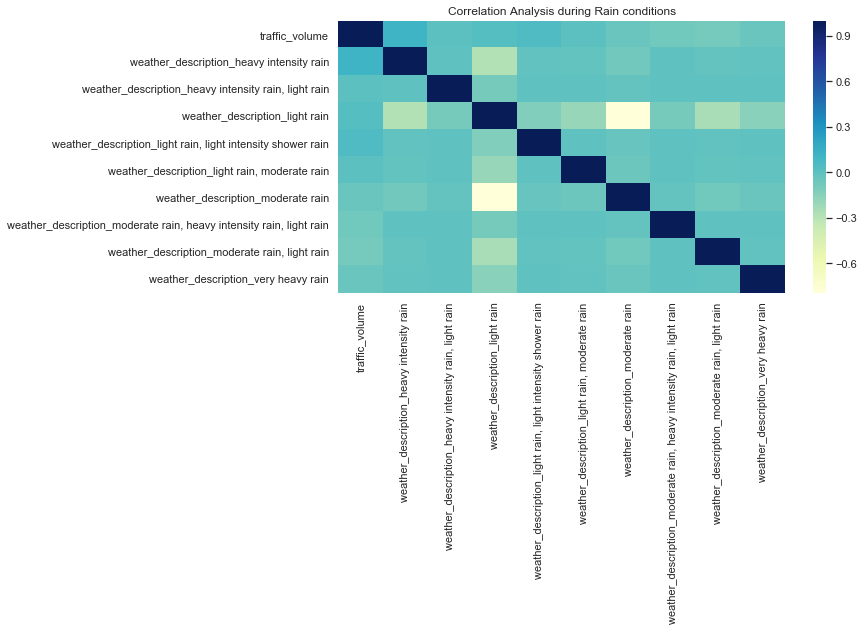

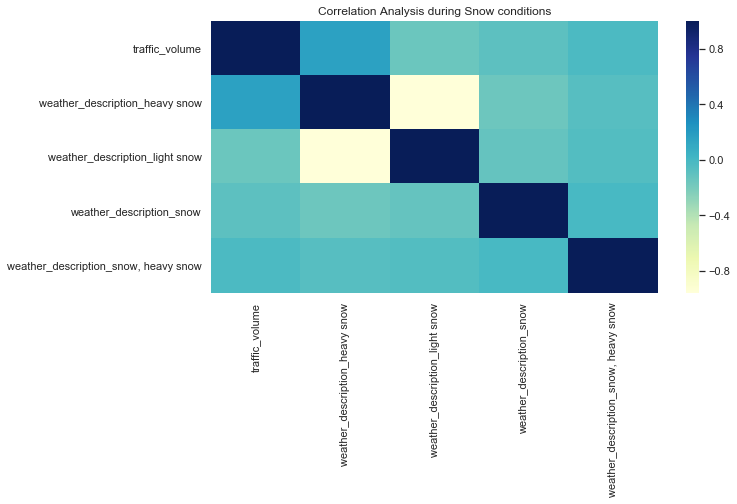

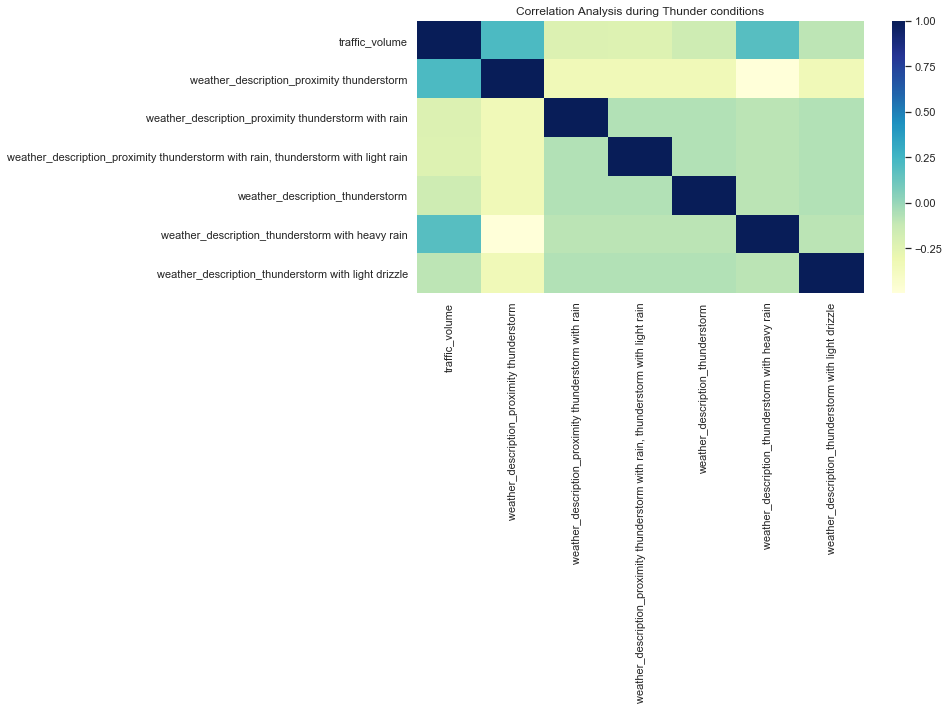

In [1018]:
for key, value in weather_list.items():
    plt.figure(figsize=(10,5))
    df_value = pd.get_dummies(value[['traffic_volume', 'weather_description']])
    sns.heatmap(df_value.corr(), cmap="YlGnBu")
    plt.xticks(rotation = 90)
    plt.title('Correlation Analysis during '+key+' conditions')

### Observations:

1) In the Clouds correlation analysis, 
- all subconditions have a slight positive correlation with traffic volume and overcast clouds has no correlation with traffic volume.

2) In the Drizzle correlation analysis, 
- light intensity drizzle has a higher correlation with traffic and subsequently heavy intensity drizzle.
- other conditions have no correlation with traffic volume

3) In the Rain correlation analysis, 
- heavy inensity rain has a higher correlation but close to 0 correlation to traffic than the other rain subconditions.

4) In the Snow correlation analysis, 
- heavy snow and snow has a positive correlation value than the other snow subsconditions.
- most subconditions are close to 0 correlation to traffic volume.

5) In the Thunder correlation analysis, 
- proximity thunderstorm has the most positive correlation wth traffic volume, followed by thunderstorm with heavy rain.
- other conditions has zero correlation with traffic volume.

## Overall Conclusions

Let's extract out columns needed for the model due to the exploratory data analysis.

In [1034]:
df.columns

Index(['clouds_all', 'date_time', 'rain_1h', 'temp', 'traffic_volume',
       'weather_description', 'weather_main', 'date_timeMonth',
       'date_timeQuarter', 'date_timeWeek', 'date_timeDay', 'date_timehour',
       'date_timeDate', 'date_timeWeekday_name', 'temp_deg', 'holiday',
       'is_Holiday'],
      dtype='object')

Due to the correlation analysis, the features below should be used as **predictors** for model.
- temp
- rain_1h
- clouds_all
- datetimeMonth
- is_Holiday

**traffic_volume** is the **dependant** variable for the model.

I will perform **feature selection** during the modelling process to validate this.

For categorical features like weather_main and weather_description, it will be good to include **thunderstorms** subconditions into the model due to slightly significant correlation values as compared to the other correlation values. This is also supported by the weather_main correlation analysis.

It will be good to include the feature **date_timeWeekday_name** as the line plot shows a different trend on weekends towards traffic volumes.